# Домашня работа №2

### Загрузка датасета

In [1]:
# !pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.models import Sequential  # Последовательность сети
from keras.layers import Dense  # Плотная нейронная сеть, полносвязная
from keras.datasets import fashion_mnist  # наборы для работы
from tensorflow.keras.utils import to_categorical  # Перевод фичей в категориальные
# Для более четкого вывода графиков
%config InlineBackend.figure_formats = ['svg']

In [3]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

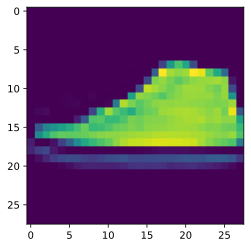

In [5]:
# plt.gray()
plt.imshow(train_images[41,:,:])
plt.show()

In [6]:
# Нормализуем
train_images = (train_images / 127) - 1
test_images = (test_images / 127) - 1
# Векторизация
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))
# Выход преобразуем в категории
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Имена классов

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Задание №1
Используем набор примеров fashion-MNIST

Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.

#### Напишем функцию которая автоматизирует наше обучение

In [8]:
def fit_model(units=100, layers=2, optimizer='Adam', batch_size=1000, epochs=20):
    """
    Обучает модель взависимости о параметров 
    И возвращает accuracy
    
    Параметры:
    units : int
        Количество нейронов в скрытом слое
    layers : int
        Количество скрытых слоев
    optimizer : str
        Оптимизатор
    """
    # Собираем модель
    model = Sequential(name='Clothes')
    for i in range(layers-1):
        # model.add(Dense(10+(10-i)*10, activation='tanh'))    
        model.add(Dense(units, activation='tanh'))   
    model.add(Dense(10, activation='softmax')) 
    # Компилируем
    model.compile(optimizer=optimizer, # оптимизатор
                  loss=keras.losses.CategoricalCrossentropy(), # функция потерь
                  metrics=['accuracy']) # метрика
    # Обучим
    with tf.device("GPU:0"):
        # with tf.device("CPU:0"):
        model.fit(train_images[:,:],
                  y_train[:,:],
                  epochs=epochs,
                  batch_size=batch_size, 
                  validation_split=0.2,
                  verbose=0)
    train_accuracy = model.history.history['accuracy'][-1]
    validation_accuracy = model.history.history['val_accuracy'][-1]
    test_accuracy = model.evaluate(test_images, y_test, verbose=0)[1]
    return train_accuracy, validation_accuracy, test_accuracy, model 

### Посмотрим различное кол-во нейровнов в 2-х слойной сети

In [9]:
results_2_layers = {'units': [],
                     'train_accuracy': [],
                     'validation_accuracy': [],
                     'test_accuracy': []}
units = np.arange(40, 600, 20)
for unit in tqdm(units):
    (train_accuracy,
     validation_accuracy,
     test_accuracy,
     model) = fit_model(units=unit, layers=2, optimizer='Adam', batch_size=1_000, epochs=20)
    results_2_layers['units'].append(unit)
    results_2_layers['train_accuracy'].append(train_accuracy)
    results_2_layers['validation_accuracy'].append(validation_accuracy)
    results_2_layers['test_accuracy'].append(test_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [02:18<00:00,  4.93s/it]


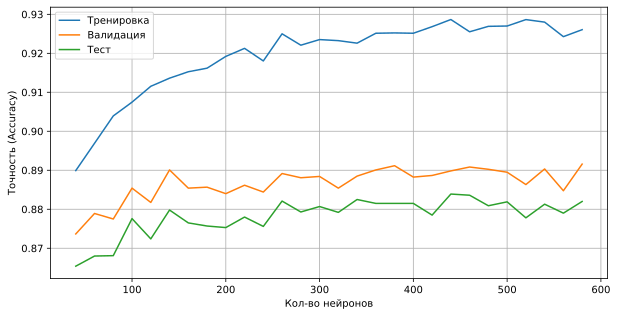

In [10]:
plt.figure(figsize=(10, 5))
plt.grid('On')
plt.ylabel('Точность (Accuracy)')
plt.xlabel('Кол-во нейронов')
plt.plot(results_2_layers['units'], results_2_layers['train_accuracy'], label = 'Тренировка')
plt.plot(results_2_layers['units'], results_2_layers['validation_accuracy'], label = 'Валидация')
plt.plot(results_2_layers['units'], results_2_layers['test_accuracy'], label = 'Тест')
plt.legend()
plt.show()

### Посмотрим разное число слоев при одинаковых параметрах сети

In [11]:
results_1 = {'layers': [],
             'train_accuracy': [],
             'validation_accuracy': [],
             'test_accuracy': []}
_layers = np.arange(1, 21, 1)
for layers in tqdm(_layers):
    (train_accuracy,
     validation_accuracy,
     test_accuracy,
     model) = fit_model(units=100, layers=layers, optimizer='Adam', batch_size=1_000, epochs=20)
    results_1['layers'].append(layers)
    results_1['train_accuracy'].append(train_accuracy)
    results_1['validation_accuracy'].append(validation_accuracy)
    results_1['test_accuracy'].append(test_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:34<00:00,  7.71s/it]


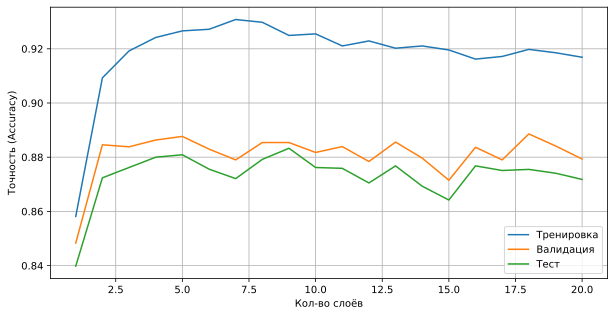

In [12]:
plt.figure(figsize=(10, 5))
plt.grid('On')
plt.ylabel('Точность (Accuracy)')
plt.xlabel('Кол-во слоёв')
plt.plot(results_1['layers'], results_1['train_accuracy'], label = 'Тренировка')
plt.plot(results_1['layers'], results_1['validation_accuracy'], label = 'Валидация')
plt.plot(results_1['layers'], results_1['test_accuracy'], label = 'Тест')
plt.legend()
plt.show()

#### Вывод:

- Для двухслойной сети оптимальное кол-во нейронов 100, далее качество растет очень медленно, и выходит на плато около 200 нейронов
- Оптимальное кол-во слоев - 3

## Задание №2
Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy

In [13]:
# Собираем модель
model = Sequential(name='Clothes')
for i in range(2):
    # model.add(Dense(10+(10-i)*10, activation='tanh'))    
    model.add(Dense(100, activation='tanh'))   
model.add(Dense(10, activation='softmax')) 
# Компилируем
model.compile(optimizer='Adam', # оптимизатор
              loss=keras.losses.CategoricalCrossentropy(), # функция потерь
              metrics=['accuracy']) # метрика

In [14]:
results_2 = {'optimizer': [],
             'train_accuracy': [],
             'validation_accuracy': [],
             'test_accuracy': []}

optimizers = ['Adam', 'SGD', 'RMSprop']
for optimizer in tqdm(optimizers):
    (train_accuracy,
     validation_accuracy,
     test_accuracy,
     model) = fit_model(units=110, layers=3, optimizer=optimizer, batch_size=1_000, epochs=30)
    results_2['optimizer'].append(optimizer)
    results_2['train_accuracy'].append(train_accuracy)
    results_2['validation_accuracy'].append(validation_accuracy)
    results_2['test_accuracy'].append(test_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.47s/it]


In [15]:
pd.DataFrame(results_2).sort_values('test_accuracy', ascending=False).reset_index(drop=True)

,optimizer,train_accuracy,validation_accuracy,test_accuracy
0,Adam,0.940667,0.888500,0.8828
1,RMSprop,0.914937,0.866667,0.8578
2,SGD,0.836187,0.831333,0.8234


#### Вывод:

Лучше всех показал себя оптимизатор **Adam**, с небольшим отрывом от **RMSprop**

## Задание №3
Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

**Эффектней всего помогло увеличение кол-ва слоев, на втором месте увеличение кол-ва нейронов**

## Задание №4

Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность).<br> Сделайте вывод.

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [17]:
# Модель
(train_accuracy,
 validation_accuracy,
 test_accuracy,
 model) = fit_model(units=110, layers=3, optimizer='Adam', batch_size=1_000, epochs=30)

In [18]:
y_pred = np.argmax(model.predict(test_images), axis=1)
y_pred[:10]

313/313 [==============================] - 0s 967us/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=int64)

In [19]:
CM = confusion_matrix(test_labels, y_pred)
print(CM)

[[881   3  16  18   2   4  69   0   7   0]
 [  4 972   1  17   2   0   4   0   0   0]
 [ 27   0 814  15  56   1  81   1   5   0]
 [ 40  15  15 873  22   2  26   0   6   1]
 [  4   1 120  40 742   0  89   0   4   0]
 [  1   0   0   0   0 964   0  20   3  12]
 [161   1  76  32  42   2 676   0  10   0]
 [  0   0   0   0   0  27   0 943   1  29]
 [  5   0   4   3   0   3  13   6 966   0]
 [  0   0   0   0   0  13   0  28   1 958]]


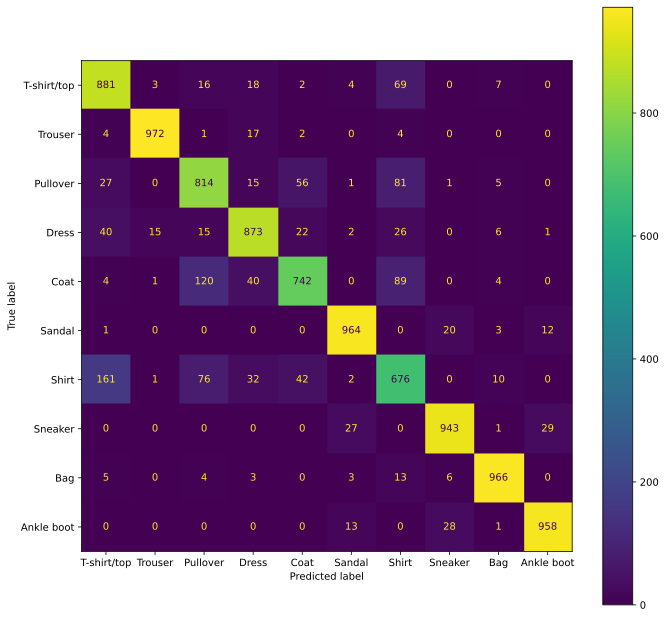

In [20]:
cfmd = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=class_names)
fig, ax = plt.subplots(figsize=(11,11))
cfmd.plot(ax=ax, values_format ='.4g')
plt.show()

#### Посчитаем Precision Recall и F1-score:

In [21]:
TP_and_FN = CM.sum(1)
TP_and_FP = CM.sum(0)
TP = CM.diagonal()
precision = TP / TP_and_FP
recall = TP / TP_and_FN
F1_score = 2 * (precision * recall) / (precision + recall)

In [22]:
result_df = pd.DataFrame({'Clothes': class_names,
                          'Precision': precision,
                          'Recall': recall,
                          'F1-score': F1_score}).sort_values('F1-score', ascending=False)
# Добавим итоговые значения
result_df = pd.concat([result_df, pd.DataFrame({'Clothes': ['TOTAL:', ],
                          'Precision': [precision.mean(), ],
                          'Recall': [recall.mean(), ],
                          'F1-score': [F1_score.mean(), ]})]).reset_index(drop=True)
result_df

,Clothes,Precision,Recall,F1-score
0,Trouser,0.979839,0.9720,0.975904
1,Bag,0.963111,0.9660,0.964553
2,Ankle boot,0.958000,0.9580,0.958000
3,Sandal,0.948819,0.9640,0.956349
4,Sneaker,0.944890,0.9430,0.943944
5,Dress,0.874749,0.8730,0.873874
6,T-shirt/top,0.784506,0.8810,0.829958
7,Pullover,0.778203,0.8140,0.795699
8,Coat,0.856813,0.7420,0.795284
9,Shirt,0.705637,0.6760,0.690501


#### Вывод:
Из интересного:
- Лучше всего распознались брюки, скоре всего из-за своей уникальной линейной формы
- Больше всего "путались" рубашка с футболкой и свитером, она же и получила худшую полноту из-за этого

Модель получилась очень хорошей особенно для первых 5-и позиций, если сортировать по F-мере, или даже, если исключить из датасета хотя бы рубашку